In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
import rebound
import numpy as np
import pandas as pd
import warnings
from multiprocessing import Process
import sys
from collections import OrderedDict
from multiprocessing import Pool
sys.path.insert(1, '..')
#print(path)
from SPOCKalt import *
sys.path.insert(1, '../SPOCKalt')
#Intigration/simsetup.py
from SPOCKalt import featureKlassifier
from SPOCKalt import simsetup

In [3]:
dataset = pd.read_csv('../modeldata/tryfirstorder3br.csv')

In [4]:
initial = pd.read_csv('../modeldata/originalCondAllData.csv')

In [5]:
test = dataset.drop(dataset[dataset['prelimStable']==True].index)
test = test.drop(test[test['Stable']==False].index)

In [6]:
plot = dataset
plot = plot.drop(plot[plot['instability_time'] <1e8].index)


In [7]:
plot = plot.drop(plot[plot['threeBRfillfac']<18].index)
plot = plot.drop(plot[plot['Stable']==False].index)
plot = plot.drop(plot[plot['index']==113762].index)
#param for 7inomolies

In [8]:
plot

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EMnear,EPnear,EMfar,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time
8989,8989,0.035150,0.072216,0.069465,0.002055,0.000119,0.795603,0.000004,1.097932e-07,0.000035,...,0.007498,0.001255,0.000795,0.000021,0.008241,0.000017,True,True,1.000049e+09,1.000049e+09
53289,53289,0.027607,0.628330,0.010454,0.001995,0.001999,0.682728,0.000028,7.539808e-06,0.000091,...,0.007178,0.018724,0.017800,0.000135,0.023586,0.000038,True,True,1.000000e+09,1.000000e+09
62512,62512,0.027607,0.628330,0.010454,0.001995,0.001999,0.682728,0.000028,7.539808e-06,0.000091,...,0.007178,0.018724,0.017800,0.000135,0.023586,0.000038,True,True,1.000000e+09,1.000000e+09
72620,72620,0.034892,0.414495,0.025368,0.002870,0.002878,0.659229,0.000006,0.000000e+00,0.000069,...,0.023746,0.016444,0.018859,0.000395,0.018505,0.000092,True,True,1.000000e+09,1.000000e+09
75295,75295,0.027607,0.628330,0.010454,0.001995,0.001999,0.682728,0.000028,7.539808e-06,0.000091,...,0.007178,0.018724,0.017800,0.000135,0.023586,0.000038,True,True,1.000000e+09,1.000000e+09
95148,95148,0.028827,0.579389,0.022892,0.002372,0.002376,0.866361,0.000265,7.771767e-07,0.000321,...,0.022519,0.006195,0.008956,0.014425,0.020867,0.014500,True,True,1.000000e+09,1.000000e+09
131943,131943,0.026609,0.092595,0.011490,0.001664,0.001667,0.710198,0.000010,5.766318e-06,0.000030,...,0.005786,0.020170,0.008942,0.028869,0.014429,0.028825,True,True,1.000000e+09,1.000000e+09


In [9]:
simlist = []
for x in plot.iloc[:,0]:
    simlist.append(simsetup.get_simList(initial.iloc[x,2:]))
for each in simlist:
    simsetup.init_sim_parameters(each)

/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

In [384]:
def farey_sequence(n):
    """Return the nth Farey sequence as order pairs of the form (N,D) where `N' is the numerator and `D' is the denominator."""
    a, b, c, d = 0, 1, 1, n
    sequence=[(a,b)]
    while (c <= n):
        k = int((n + b) / d)
        a, b, c, d = c, d, (k*c-a), (k*d-b)
        sequence.append( (a,b) )
    return sequence

def resonant_period_ratios(min_per_ratio,max_per_ratio,order):
    """Return the period ratios of all resonances up to order 'order' between 'min_per_ratio' and 'max_per_ratio' """
    if min_per_ratio < 0.:
        raise AttributeError("min_per_ratio of {0} passed to resonant_period_ratios can't be < 0".format(min_per_ratio))
    if max_per_ratio >= 1.:
        raise AttributeError("max_per_ratio of {0} passed to resonant_period_ratios can't be >= 1".format(max_per_ratio))
    minJ = int(np.floor(1. /(1. - min_per_ratio)))
    maxJ = int(np.ceil(1. /(1. - max_per_ratio)))
    res_ratios=[(minJ-1,minJ)]
    for j in range(minJ,maxJ):
        res_ratios = res_ratios + [ ( x[1] * j - x[1] + x[0] , x[1] * j + x[0]) for x in farey_sequence(order)[1:] ]
    res_ratios = np.array(res_ratios)
    msk = np.array( list(map( lambda x: min_per_ratio < x[0]/float(x[1]) < max_per_ratio , res_ratios )) )
    return res_ratios[msk]

import rebound
def ratio_list(sim: rebound.Simulation, i1, i2):
    maxorder = 5
    ps = sim.particles
    #print('test')
    n1 = ps[i1].n
    n2 = ps[i2].n

    m1 = ps[i1].m/ps[0].m
    m2 = ps[i2].m/ps[0].m

    Pratio = n2/n1
    #next want to try not to abreviate to closest

    delta = 0.03
    if Pratio < 0 or Pratio > 1: # n < 0 = hyperbolic orbit, Pratio > 1 = orbits are crossing
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    minperiodratio = max(Pratio-delta, 0.)
    maxperiodratio = min(Pratio+delta, 0.99) # too many resonances close to 1
    res = resonant_period_ratios(minperiodratio,maxperiodratio, order=maxorder)
    return res


def ratio(sim: rebound.Simulation, i1, i2):
    ps = sim.particles
    real = ps[i1].P/ ps[i2].P
    which = int
    val = [10000,10]
    #print(ratio_list(sim,i1,i2))
    for i,each in enumerate(ratio_list(sim,i1,i2)):
        if np.abs((each[0]/each[1])-real)<np.abs((val[0]/val[1])-real):
            #which = i
            val = each
    return val

# def getTheta(sim, i1,i2, rat):
#     ps = sim.particles
#     #rat = ratio(sim, i1,i2)
#     #print(rat)
#     #evec = (ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega), ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))
#     #pomega = np.arctan(evec[1]/evec[0])
#     evec2 = ps[i2].e*np.exp(1j*ps[i2].pomega)
#     evec1 = ps[i1].e*np.exp(1j*ps[i1].pomega)
#     erel = evec2-evec1
#     pomegarel=np.angle(erel)
#     #theta = (rat[1]*ps[i2].l) -(rat[0]*ps[i1].l)-(lambda x : x+(2*np.pi) if x<0 else x )(pomegarel)
#     theta = (rat[1]*ps[i2].l) -(rat[0]*ps[i1].l)-(rat[1]-rat[0])*pomegarel

#    return theta

def getPomega(sim, i1, i2):
    ps = sim.particles
    evec2 = ps[i2].e*np.exp(1j*ps[i2].pomega)
    evec1 = ps[i1].e*np.exp(1j*ps[i1].pomega)
    erel = evec2-evec1
    pomegarel=np.angle(erel)
    return pomegarel

def retTheta(la,lb, pomegarel, Pratio: list):
    maxorder = 5
    delta = 0.03
    minperiodratio = max(Pratio-delta, 0.)
    maxperiodratio = min(Pratio+delta, 0.99) # too many resonances close to 1
    res = resonant_period_ratios(minperiodratio,maxperiodratio, order=maxorder)
    val = [10000000,10]
    for i,each in enumerate(res):
        if np.abs((each[0]/each[1])-Pratio)<np.abs((val[0]/val[1])-Pratio):
            #which = i
            
            val = each
    
    theta = (val[1]*lb) -(val[0]*la)-(val[1]-val[0])*pomegarel

    return np.mod(theta, 2*np.pi)


def get_data(sim, Nint, Nout):
    '''gets dataframe '''
    times = np.linspace(0,Nint,Nout)
    data = pd.DataFrame()
    theta12 = np.zeros(Nout)
    theta23 = np.zeros(Nout)
    p2p1 = np.zeros(Nout)
    p3p2 = np.zeros(Nout)
    e1 = np.zeros(Nout)
    e2 = np.zeros(Nout)
    e3 = np.zeros(Nout)
    l1 = np.zeros(Nout)
    l2 = np.zeros(Nout)
    l3 = np.zeros(Nout)
    pomegarel12 = np.zeros(Nout)
    pomegarel23 = np.zeros(Nout)
    theta12 = np.zeros(Nout)
    theta23 = np.zeros(Nout)
    
    
    ps = sim.particles
    for i,each in enumerate(times):
        p2p1[i] = ((ps[2].P/ps[1].P))
        p3p2[i]=((ps[3].P/ps[2].P))
        e1[i]=(ps[1].e)
        e2[i]=(ps[2].e)
        e3[i]=(ps[3].e)
        l1[i]=(ps[1].l)
        l2[i]=(ps[2].l)
        l3[i]=(ps[3].l)
        pomegarel12[i]=(getPomega(sim,1,2))
        pomegarel23[i]=(getPomega(sim,2,3))

        sim.integrate(each, exact_finish_time=0)

    Pratio12 = 1/np.median(p2p1)
    Pratio32 = 1/np.median(p3p2)
    #print(pomegarel12)
    for x in range(Nout):
        theta12[x]=retTheta(l1[x],l2[x],pomegarel12[x],Pratio12)
        theta23[x]=retTheta(l2[x],l3[x],pomegarel23[x],Pratio32)
    
    data=pd.DataFrame({'time':times,'p2/p1':p2p1,'p3/p2':p3p2,'theta12':theta12,'theta23':theta23,'e1':e1,'e2':e2,'e3':e3})
    return data


def plot_data(sim,Nout,Nint):
    data = get_data(sim,Nout,Nint)
    data.plot.scatter(x="p2/p1", y="p3/p2",s=2, c="time", colormap="copper", alpha=.5)
    data.plot.scatter(x="time", y="theta12",figsize=(14,7),s=1)
    data.plot.scatter(x="time", y="theta23",figsize=(14,7),s=1)
    # data.plot.scatter(x="time", y="rat",figsize=(14,7),s=1)

    data.plot(x='time',y=['e1','e2','e3'],figsize=(14,7))
    rebound.OrbitPlot(sim)


In [10]:
import plotFunctions

all exceptions have the same weirdly shaped theta23 plot as well as almost identical period ratio plots, main thing, increadbly compact outer pair

/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

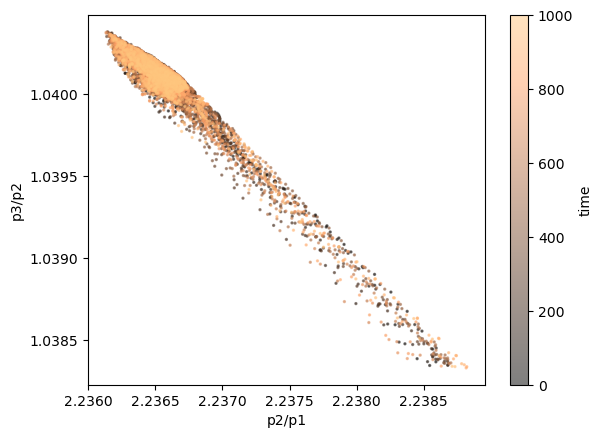

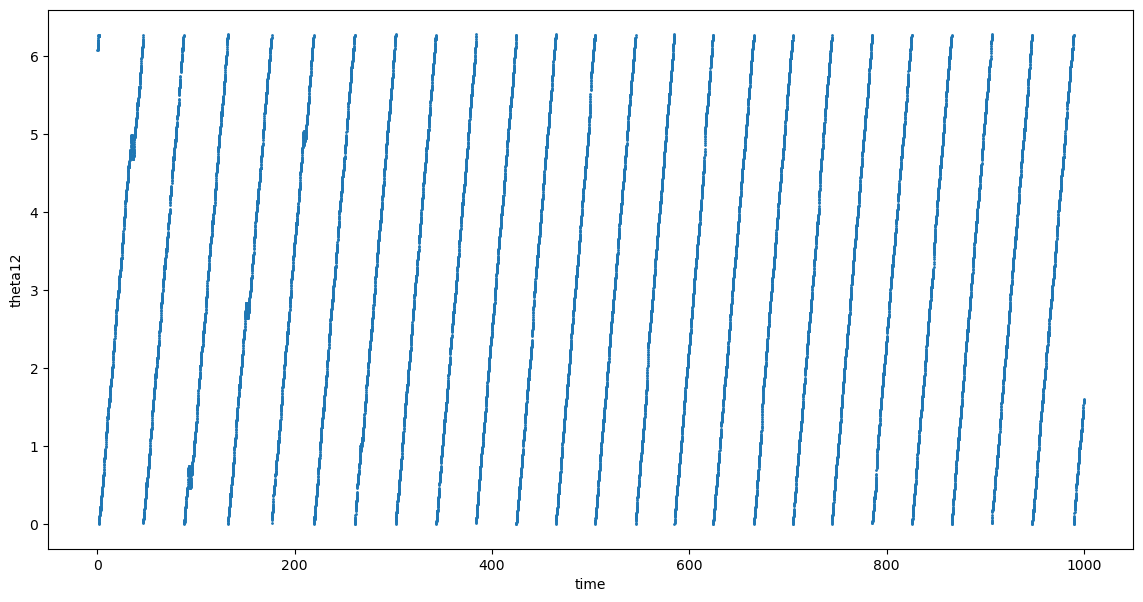

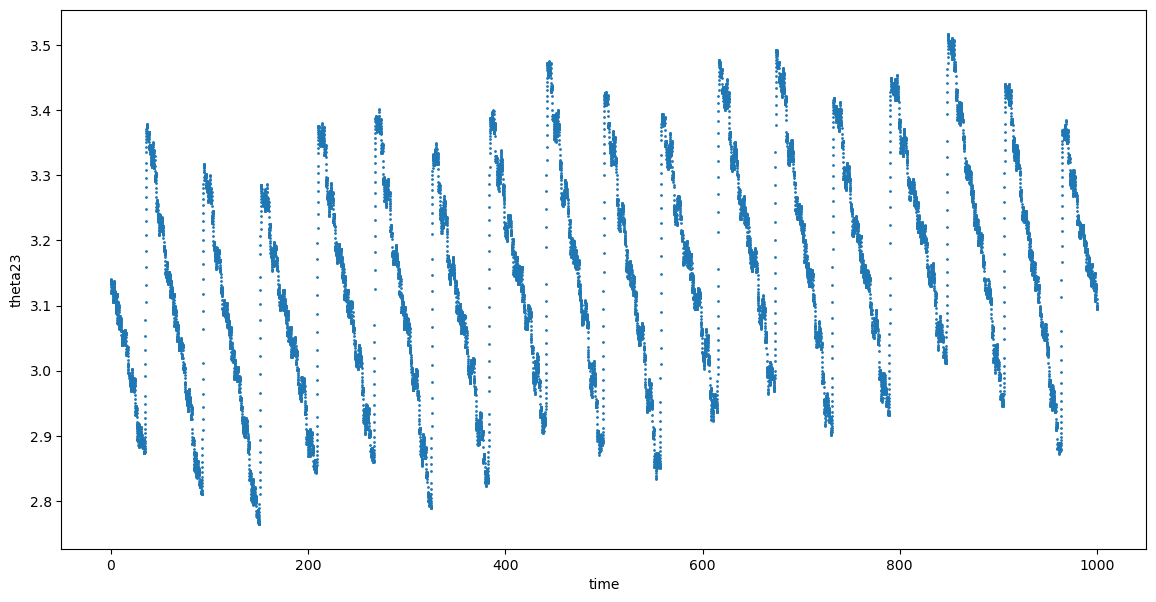

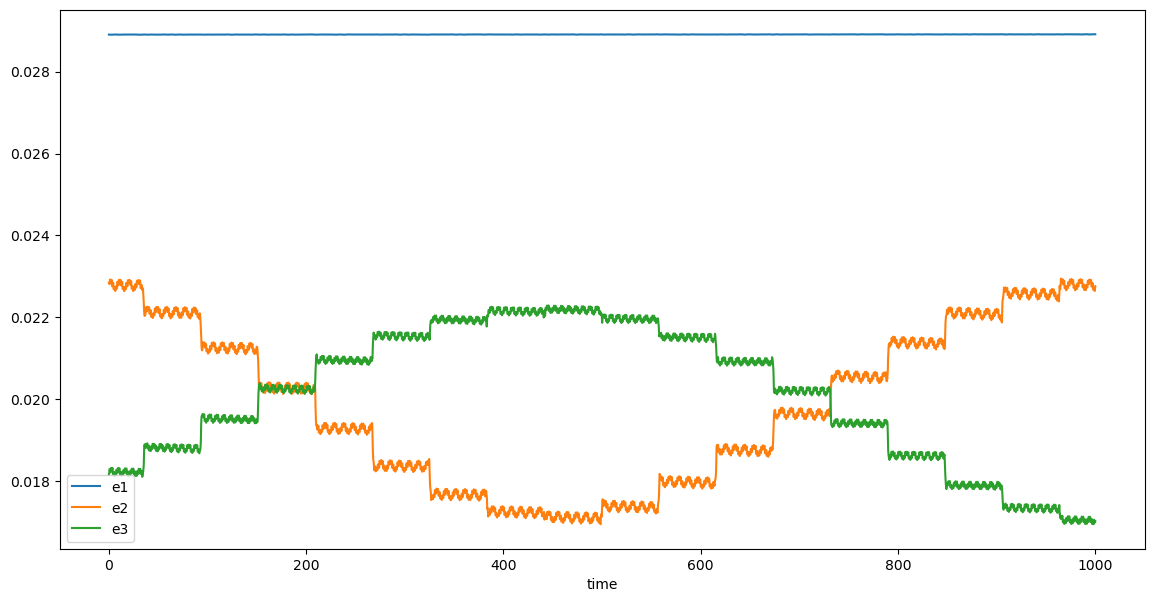

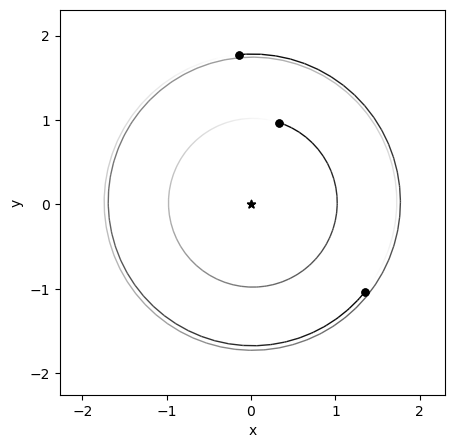

In [12]:
sim = simsetup.get_simList(initial.iloc[131943,2:])
simsetup.init_sim_parameters(sim)
plotFunctions.plot_data(sim,1000,20000)

In [249]:
#em/ecross dictates order

In [48]:
ps = sim.particles

In [53]:
ps[3].a - ps[2].a

0.058941356543500856

In [53]:
sim = simsetup.get_simList(initial.iloc[138282,2:])
simsetup.init_sim_parameters(sim)
plot_data(sim,10000000,5000000)


/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
/home/ethadhani/summerSPOCK/datafilt/../SPOCKalt/simsetup.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

In [24]:
def integrate(sim):
    Nout = 1000
    Nint = 8
    times = np.linspace(0,Nint,Nout)
    
    p2p1 = []
    p3p2 = []
    ps = sim.particles
    for time in times:
        try:
            sim.integrate(10**time, exact_finish_time=0)
            p2p1.append((ps[2].P/ps[1].P))
            p3p2.append((ps[3].P/ps[2].P))
            #print(p2p1)
        except:
            p2p1.append(np.nan)
            p3p2.append(np.nan)
        #labels = [lable]*Nout
    tseries = pd.DataFrame({'p2/p1': p2p1, 'p3/p2': p3p2, 'times': times})


    return tseries


In [ ]:
%%time
if __name__ == "__main__":  # confirms that the code is under main function

    
    with Pool() as p:
        new = list(p.map(int, simlist))
    # test = list(map(runInt, bound))
    # print(test)
    data = pd.concat(new)
 

In [ ]:
plt.scatter()